# PPCA in PyStan

In this notebook, we try to perform a PPCA in Pystan.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

Here, the model is defined in Stan.

In [2]:
latent = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    for (d in 1:D)
        W[d] ~ normal(0.0,sigma);
    sigma~lognormal(0.0, 1.0) ;
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca = pystan.StanModel(model_code=latent)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8f34402276fb5cc67587951916679ef NOW.


We specify our parameters and generate some data.

In [3]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(N,M))
sigma = np.random.lognormal(0,1)
W = np.random.normal(0,sigma,size=(M,D))
x = np.random.normal(np.matmul(z,W),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x}

And then we can optimize our parameters and latent dataset.

In [4]:
op = ppca.optimizing(data=ppca_dat)

z_sim = op['z'].T
sigma_sim = op['sigma']
W_sim = op['W'].T
x_sim = np.random.normal(np.matmul(z_sim,W_sim),sigma_sim)

print('real sigma: ', sigma)
print('simulated sigma: ', sigma_sim)
print()
print('real z: ', z)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('simulated W: ', W_sim)
print()

real sigma:  1.0178173303097378
simulated sigma:  0.5855823649710952

real z:  [[-0.20947632 -0.72290729]
 [-0.27919225 -0.65370401]
 [-0.10839018  0.92924513]
 ...
 [ 1.50223247 -0.09082188]
 [-0.13045826 -1.53899844]
 [ 1.44689696  1.78919426]]
simulated z:  [[-0.15287462 -0.095714  ]
 [-0.21163668 -0.15745014]
 [-0.02090134 -0.03449319]
 ...
 [-0.52462421  0.22815716]
 [ 0.049071   -0.41902205]
 [-0.19015531  0.50781465]]

real W:  [[ 0.46368211  0.73063144  0.70619758]
 [-0.04390018  0.04638852  0.65856219]]
simulated W:  [[-2.50702401 -3.62059083  1.56067734]
 [ 0.95696127  2.1623495   4.79716616]]



The result is plotted below. Similarly to what happened in TensorFlow Probability, the observed data $x$ is predicted accurately, but the latent data $z$ is not. The value for $\sigma$ is also off.

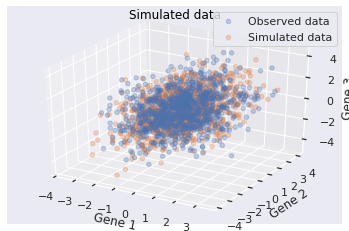

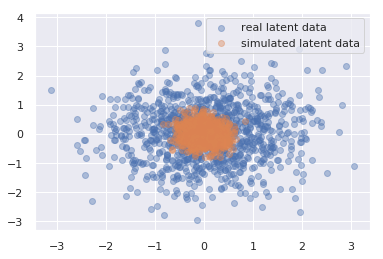

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim[:,0],x_sim[:,1],x_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[:,0], z[:,1], label='real latent data', alpha=0.4)
plt.scatter(z_sim[:,0], z_sim[:,1], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()